In [1]:
import plot
import importlib
import numpy as np
import random
import os
import glob
import h5py
import math
import scipy
import random
import classify
import warnings
import preprocess
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from os import path
from scipy import stats
from scipy.io import loadmat
from matplotlib import gridspec
from numpy.linalg import norm
from scipy.spatial import distance
from sklearn import decomposition
from matplotlib.colors import LinearSegmentedColormap
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

np.random.seed(42)
random.seed(42)


In [2]:

# reload when updating code
importlib.reload(preprocess)
# mouse and date

mice = ['NN11'] 
dates_per_mouse = {'NN11': ['210626']}

for mouse in mice:
    dates = dates_per_mouse[mouse]  # Get the list of dates for the current mouse
    days = len(dates)  # Correct number of days for this mouse
    
    for day_idx, date in enumerate(dates):
        print(mouse, date)
        
        # Create folders to save files
        paths = preprocess.create_folders(mouse, date)
        print('folders created')
        
        # Import data for mouse and date as dict
        session_data = preprocess.load_data(paths)
        print('data loaded')
        
        # Process and plot behavior
        behavior = preprocess.process_behavior(session_data, paths)
        print('behavior done')
        
        # Save masks so can run in Matlab to process other planes
        # preprocess.cell_masks(paths, 0)
        print('masks saved')
        
        # Grab activity
        deconvolved = preprocess.process_activity(paths, 'spks', 3, 0)
        print('activity processed')
        
        # Normalize activity
        norm_deconvolved = preprocess.normalize_deconvolved(deconvolved, behavior, paths, 0)
        print('activity normalized')
        
        # Gaussian filter activity
        norm_moving_deconvolved_filtered = preprocess.difference_gaussian_filter(norm_deconvolved, 4, behavior, paths, 0)
        print('activity filtered')
        
        # Make trial-averaged traces and baseline subtract
        mean_cs_1_responses_df = preprocess.normalized_trial_averaged(norm_deconvolved, behavior, 'cs_1')
        mean_cs_2_responses_df = preprocess.normalized_trial_averaged(norm_deconvolved, behavior, 'cs_2')
        print('traces done')
        
        # Get significant cells
        [cs_1_poscells, cs_1_negcells] = preprocess.sig_test(norm_deconvolved, behavior, 'cs_1')
        [cs_2_poscells, cs_2_negcells] = preprocess.sig_test(norm_deconvolved, behavior, 'cs_2')
        [both_poscells, both_sigcells] = preprocess.combine_sig(cs_1_poscells, cs_1_negcells, cs_2_poscells, cs_2_negcells)
        print('sig cells done')
        
        # Get index of top cell differences
        idx = preprocess.get_index(behavior, mean_cs_1_responses_df, mean_cs_2_responses_df, cs_1_poscells, cs_2_poscells, both_poscells, both_sigcells, paths, 1)
        print('idx done')
        
        # Get prior for synchronous cue activity
        prior = classify.prior(norm_moving_deconvolved_filtered, idx['cs_1'], idx['cs_2'], behavior, [])
        print('prior done')
        
        # Logistic regression
        y_pred_log = classify.log_regression(behavior, norm_deconvolved, norm_moving_deconvolved_filtered, both_poscells, prior)
        print('logistic regression done')
        
        # Process classified output
        y_pred = classify.process_classified(y_pred_log, prior, paths, 1)
        print('classified done')
    


NN11 210626
folders created
data loaded
behavior done
masks saved
activity processed
activity normalized
activity filtered
traces done
sig cells done
idx done
prior done
logistic regression done
classified done


In [52]:
activity = norm_deconvolved.to_numpy()
activity = activity[idx['both'].index]

# Commented out code for filtering significant reactivated cells.
# sig_cells = preprocess.sig_reactivated_cells([], [], [], [], [], paths, 0)
# activity = activity[sig_cells > 0, :]

# Initialize lists to store mean activities and onsets for two different cues.
mean_activity_cs_1 = []
mean_activity_cs_2 = []
mean_activity_cs_any = []
onsets_cs_1 = []
onsets_cs_2 = []

# Loop over each onset and offset in behavior data.
for i in range(0, len(behavior['onsets'])):
    # Calculate the mean activity for the given onset to offset period.
    temp_activity = np.mean(activity[:, int(behavior['onsets'][i]):int(behavior['offsets'][i]) + 1], axis=1)
    # Check if the cue code matches cs_1_code, and store the mean activity and onset.
    if behavior['cue_codes'][i] == behavior['cs_1_code']:
        mean_activity_cs_1.append(temp_activity)
        onsets_cs_1.append(behavior['onsets'][i])
        mean_activity_cs_any.append(temp_activity)
    # Check if the cue code matches cs_2_code, and store the mean activity and onset.
    if behavior['cue_codes'][i] == behavior['cs_2_code']:
        mean_activity_cs_2.append(temp_activity)
        onsets_cs_2.append(behavior['onsets'][i])
        mean_activity_cs_any.append(temp_activity)

cos_sim = lambda a, b: np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
topn = 0.05

# Commented out code for filtering significant reactivated cells.
# sig_cells = preprocess.sig_reactivated_cells([], [], [], [], [], paths, 0)
# activity = activity[sig_cells > 0, :]

# Initialize lists to store mean activities and onsets for two different cues.
mean_activity_cs_1 = []
mean_activity_cs_2 = []
mean_activity_cs_any = []
onsets_cs_1 = []
onsets_cs_2 = []

# Loop over each onset and offset in behavior data.
for i in range(0, len(behavior['onsets'])):
    # Calculate the mean activity for the given onset to offset period.
    temp_activity = np.mean(activity[:, int(behavior['onsets'][i]):int(behavior['offsets'][i]) + 1], axis=1)
    # Check if the cue code matches cs_1_code, and store the mean activity and onset.
    if behavior['cue_codes'][i] == behavior['cs_1_code']:
        mean_activity_cs_1.append(temp_activity)
        onsets_cs_1.append(behavior['onsets'][i])
        mean_activity_cs_any.append(temp_activity)
    # Check if the cue code matches cs_2_code, and store the mean activity and onset.
    if behavior['cue_codes'][i] == behavior['cs_2_code']:
        mean_activity_cs_2.append(temp_activity)
        onsets_cs_2.append(behavior['onsets'][i])
        mean_activity_cs_any.append(temp_activity)

# Normalize the mean activities for each trial.
mean_activity_cs_1 = mean_activity_cs_1 / np.mean(mean_activity_cs_any, axis=0)
mean_activity_cs_2 = mean_activity_cs_2 / np.mean(mean_activity_cs_any, axis=0)

mean_activity_cs_1 = np.stack(mean_activity_cs_1, axis=0)
mean_activity_cs_2 = np.stack(mean_activity_cs_2, axis=0)

# Calculate the mean of the first and last three mean activities for cs_1 and cs_2.
n_centroids = 3
mean_activity_cs_1_mean = [np.mean(mean_activity_cs_1[0:n_centroids], axis=0), np.mean(mean_activity_cs_1[len(mean_activity_cs_1) - n_centroids:len(mean_activity_cs_1)], axis=0)]
mean_activity_cs_2_mean = [np.mean(mean_activity_cs_2[0:n_centroids], axis=0), np.mean(mean_activity_cs_2[len(mean_activity_cs_2) - n_centroids:len(mean_activity_cs_2)], axis=0)]

# Calculate the difference vectors between the early and late mean activities for cs_1 and cs_2.
mean_activity_cs_1_vec = mean_activity_cs_1_mean[1] - mean_activity_cs_1_mean[0]
mean_activity_cs_2_vec = mean_activity_cs_2_mean[1] - mean_activity_cs_2_mean[0]

late_trails_1 = mean_activity_cs_1_mean[1]
top_n_percent_indices_1 = np.argsort(late_trails_1)[-int(len(late_trails_1) * topn):]
mean_activity_cstopn_1 = mean_activity_cs_1[:, top_n_percent_indices_1]
mean_activity_cstopn_1_late = mean_activity_cs_1_mean[1][top_n_percent_indices_1]

late_trails_2 = mean_activity_cs_2_mean[1]
top_n_percent_indices_2 = np.argsort(late_trails_2)[-int(len(late_trails_2) * topn):]
mean_activity_cstopn_2 = mean_activity_cs_2[:, top_n_percent_indices_2]
mean_activity_cstopn_2_late = mean_activity_cs_2_mean[1][top_n_percent_indices_2]

sim_cs_1 = np.zeros(len(mean_activity_cs_1))
sim_cs_2 = np.zeros(len(mean_activity_cs_2))

# Normalize the mean activities for each trial using the difference vectors.
for i in range(0, len(mean_activity_cs_1)):
    sim_cs_1[i] = cos_sim(mean_activity_cstopn_1[i], mean_activity_cstopn_1_late)
    # sim_cs_1[i] = cos_sim(mean_activity_cs_1[i], mean_activity_cs_1_mean[1])
    # sim_cs_1[i] = np.dot(mean_activity_cs_1[i], mean_activity_cs_1_vec) / np.linalg.norm(mean_activity_cs_1_vec)
for i in range(0, len(mean_activity_cs_2)):
    sim_cs_2[i] = cos_sim(mean_activity_cstopn_2[i], mean_activity_cstopn_2_late)
    # sim_cs_2[i] = cos_sim(mean_activity_cs_2[i], mean_activity_cs_2_mean[1])
    # sim_cs_2[i] = np.dot(mean_activity_cs_2[i], mean_activity_cs_2_vec) / np.linalg.norm(mean_activity_cs_2_vec)


# Initialize lists to store mean activities and trial indices for reactivation events.
mean_activity_r_1 = []
mean_activity_r_2 = []
mean_activity_r_any = []
trial_r_1 = []
trial_r_2 = []

# Copy reactivation predictions for cs_1 and cs_2.
reactivation_cs_1 = y_pred[:, 0].copy()
reactivation_cs_2 = y_pred[:, 1].copy()

# Set a threshold for reactivation probability.
p_threshold = .75

# Initialize variables for reactivation event detection.
cs_1_peak = 0
cs_2_peak = 0
i = 0
next_r = 0

# Loop through reactivation predictions to detect reactivation events.
while i < len(reactivation_cs_1) - 1:
    # Check if there is a reactivation event.
    if reactivation_cs_1[i] > 0 or reactivation_cs_2[i] > 0:
        if next_r == 0:
            r_start = i
            next_r = 1
        # Update peak reactivation values.
        if reactivation_cs_1[i] > cs_1_peak:
            cs_1_peak = reactivation_cs_1[i]
        if reactivation_cs_2[i] > cs_2_peak:
            cs_2_peak = reactivation_cs_2[i]
        #print(reactivation_cs_1[i + 1], reactivation_cs_2[i + 1])
        # Check if the reactivation event has ended.
        if reactivation_cs_1[i + 1] <= 0.001 and reactivation_cs_2[i + 1]<= 0.001:
            r_end = i + 1
            next_r = 0
            # Store mean activity and trial index for cs_1 reactivation events above the threshold.
            if cs_1_peak > p_threshold:
                for j in range(0, len(onsets_cs_1)):
                    if r_start < onsets_cs_1[j] and r_start > onsets_cs_1[j-1] and r_start < onsets_cs_1[j-1] + int(behavior['framerate']*61):
                        mean_activity_r_1.append(np.mean(activity[:, r_start:r_end], axis=1))
                        trial_r_1.append(j-1)
                        mean_activity_r_any.append(np.mean(activity[:, r_start:r_end], axis=1))
                        break
            # Store mean activity and trial index for cs_2 reactivation events above the threshold.
            if cs_2_peak > p_threshold:
                for j in range(0, len(onsets_cs_2)):
                    if r_start < onsets_cs_2[j] and r_start > onsets_cs_2[j-1] and r_start < onsets_cs_2[j-1] + int(behavior['framerate']*61):
                        mean_activity_r_2.append(np.mean(activity[:, r_start:r_end], axis=1))
                        trial_r_2.append(j-1)
                        mean_activity_r_any.append(np.mean(activity[:, r_start:r_end], axis=1))
                        break
            # Reset variables for the next reactivation event.
            i = r_end
            cs_1_peak = 0
            cs_2_peak = 0
    i += 1


# Normalize the reactivation mean activities.
mean_activity_r_1 = mean_activity_r_1 / np.mean(mean_activity_r_any, axis=0)
mean_activity_r_2 = mean_activity_r_2 / np.mean(mean_activity_r_any, axis=0)

mean_activity_r_1 = np.stack(mean_activity_r_1, axis=0)
mean_activity_r_2 = np.stack(mean_activity_r_2, axis=0)

# mean_activity_rtopn_1 = mean_activity_r_1[:, top_n_percent_indices_1]
# mean_activity_cstopn_1_late = mean_activity_cs_1_mean[1][top_n_percent_indices_1]

# mean_activity_rtopn_2 = mean_activity_r_2[:, top_n_percent_indices_2]
# mean_activity_cstopn_2_late = mean_activity_cs_2_mean[1][top_n_percent_indices_2]

sim_r_1 = np.zeros(len(mean_activity_r_1))
sim_r_2 = np.zeros(len(mean_activity_r_2))

sim_r_1_random = np.zeros(len(mean_activity_r_1))

zero_indices = np.where(mean_activity_r_1 != 0)
    
# Normalize the reactivation mean activities using the difference vectors.
for i in range(0, len(mean_activity_r_1)):
    # nonzero_indices = np.where(mean_activity_r_1[i] != 0)
    top_n_percent_indices_r_1 = np.argsort(mean_activity_r_1[i])[-int(len(mean_activity_r_1[i]) * topn):]
    sim_r_1[i] = cos_sim(mean_activity_r_1[i][np.intersect1d(top_n_percent_indices_r_1, top_n_percent_indices_1)], mean_activity_cs_1_mean[1][np.intersect1d(top_n_percent_indices_r_1, top_n_percent_indices_1)])
    
    chosen_indices = np.random.randint(0, len(mean_activity_r_1[i]), 27)
    sim_r_1_random[i] = cos_sim(mean_activity_r_1[i][chosen_indices], mean_activity_cs_1_mean[1][chosen_indices])
    # sim_r_1[i] = cos_sim(mean_activity_rtopn_1[i], mean_activity_cstopn_1_late)
    # sim_r_1[i] = cos_sim(mean_activity_r_1[i], mean_activity_cs_1_mean[1])
    # sim_r_1[i] = np.dot(mean_activity_r_1[i], mean_activity_cs_1_vec) / np.linalg.norm(mean_activity_cs_1_vec)
for i in range(0, len(mean_activity_r_2)):
    # nonzero_indices = np.where(mean_activity_r_2[i] != 0)
    top_n_percent_indices_r_2 = np.argsort(mean_activity_r_2[i])[-int(len(mean_activity_r_2[i]) * topn):]
    sim_r_2[i] = cos_sim(mean_activity_r_2[i][np.intersect1d(top_n_percent_indices_r_2, top_n_percent_indices_2)], mean_activity_cs_2_mean[1][np.intersect1d(top_n_percent_indices_r_2, top_n_percent_indices_2)])
    # sim_r_2[i] = cos_sim(mean_activity_rtopn_2[i], mean_activity_cstopn_2_late)
    # sim_r_2[i] = cos_sim(mean_activity_r_2[i], mean_activity_cs_2_mean[1])
    # sim_r_2[i] = np.dot(mean_activity_r_2[i], mean_activity_cs_2_vec) / np.linalg.norm(mean_activity_cs_2_vec)



In [53]:
def compute_drift_per_trial(activity_matrix):
    """
    Compute drift (current trial - previous trial) for each neuron.
    :param activity_matrix: Trials x Neurons matrix of activity
    :return: Drift matrix (Trials-1 x Neurons)
    """
    return activity_matrix[1:, :] - activity_matrix[:-1, :]

drift_cs_1 = compute_drift_per_trial(mean_activity_cs_1)  # Shape: (trials-1, neurons)
drift_cs_2 = compute_drift_per_trial(mean_activity_cs_2)  # Shape: (trials-1, neurons)


In [54]:
from scipy.stats import t

drift_r_1 = drift_cs_1[trial_r_1]  # Reactivation drift values for stimulus 1
drift_r_2 = drift_cs_2[trial_r_2]

# Step 3: Compute correlations for each neuron
# Compute correlations between r1 activity and drift_cs_1
correlations_r1 = [
    np.corrcoef(mean_activity_r_1[:, neuron], drift_r_1[:, neuron])[0, 1]
    for neuron in range(mean_activity_r_1.shape[1])
]

# Compute correlations between r2 activity and cs_2
correlations_r2 = [
    np.corrcoef(mean_activity_r_2[:, neuron], drift_r_2[:, neuron])[0, 1]
    for neuron in range(mean_activity_r_2.shape[1])
]

def correlation_p_value(r, n):
    """Compute the p-value for a given correlation coefficient."""
    t_stat = r * np.sqrt((n - 2) / (1 - r**2))
    p_value = 2 * t.sf(np.abs(t_stat), df=n - 2)  # Two-tailed test
    return p_value

# Step 1: Compute p-values for r1
num_trials = mean_activity_r_1.shape[0]
p_values_r1 = [correlation_p_value(r, num_trials) for r in correlations_r1]

# Step 2: Compute p-values for r2
num_trials_r2 = mean_activity_r_2.shape[0]
p_values_r2 = [correlation_p_value(r, num_trials_r2) for r in correlations_r2]

# Step 3: Identify significant neurons
significant_neurons_r1 = [neuron for neuron, p in enumerate(p_values_r1) if p < 0.05]
significant_neurons_r2 = [neuron for neuron, p in enumerate(p_values_r2) if p < 0.05]

# Step 4: Print significant neurons
print(f"Significant neurons from r1: {len(significant_neurons_r1)} out of {len(correlations_r1)}")
print(f"Significant neurons from r2: {len(significant_neurons_r2)} out of {len(correlations_r2)}")




Significant neurons from r1: 247 out of 3124
Significant neurons from r2: 188 out of 3124


In [55]:
r1_sig_act = mean_activity_cs_1[:, significant_neurons_r1]
r2_sig_act = mean_activity_cs_2[:, significant_neurons_r2]


MSE: 0.0192, R-squared: 0.4574, Accuracy: 5.08%


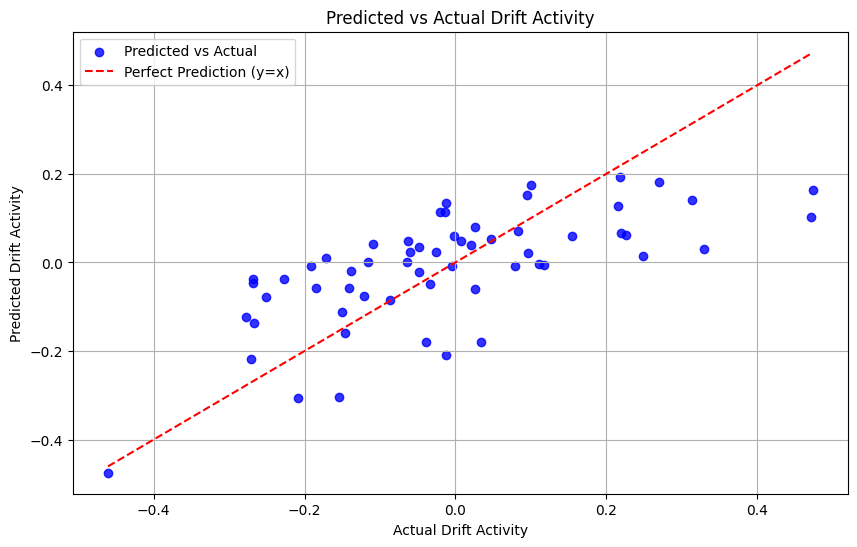

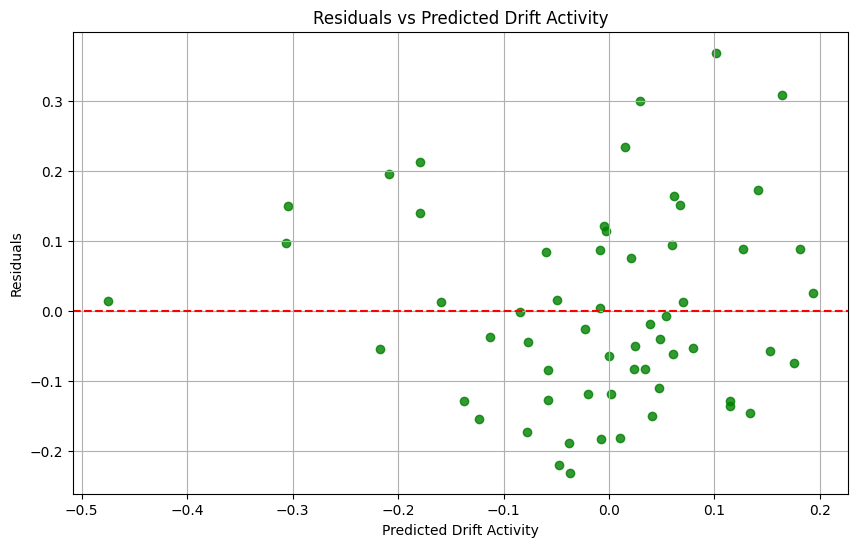

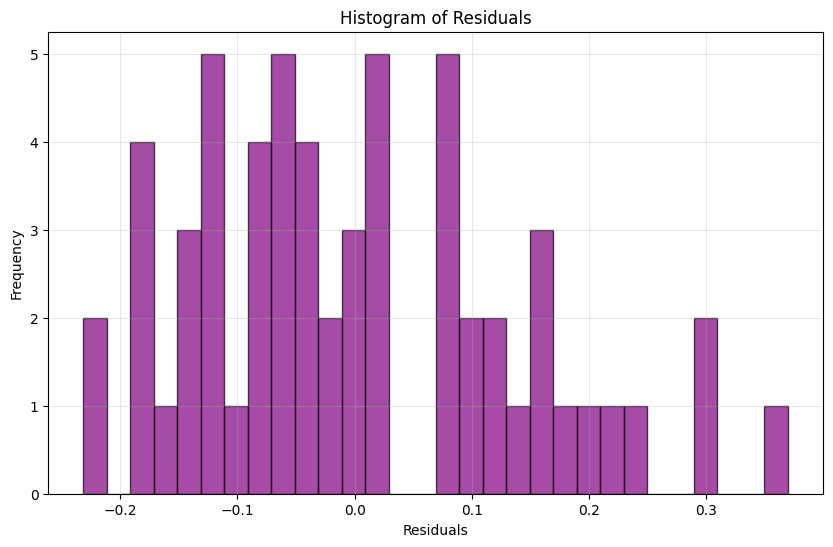

In [57]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Assuming mean_drift_cs_1 and mean_overlap_cs_1 are precomputed
mean_drift_cs_1 = drift_cs_2.mean(axis=1)  # Mean across neurons for each trial
mean_overlap_cs_1 = r2_sig_act[:-1, ].mean(axis=1)

# Reshape data for regression
X = mean_overlap_cs_1.reshape(-1, 1)  # Input: Overlapping activity
y = mean_drift_cs_1  # Output: Drift activity

# Fit a linear regression model
model = LinearRegression()
model.fit(X, y)

# Predict drift activity
predicted_drift = model.predict(X)

# Residuals
residuals = y - predicted_drift

# Metrics
mse = mean_squared_error(y, predicted_drift)
r2 = r2_score(y, predicted_drift)
accuracy = np.mean(np.abs(predicted_drift - y) <= 0.1 * np.abs(y)) * 100

print(f"MSE: {mse:.4f}, R-squared: {r2:.4f}, Accuracy: {accuracy:.2f}%")


# Visualization: Predicted vs Actual Drift Activity
plt.figure(figsize=(10, 6))
plt.scatter(y.flatten(), predicted_drift.flatten(), alpha=0.8, color='blue', label="Predicted vs Actual")
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--', label="Perfect Prediction (y=x)")
plt.title("Predicted vs Actual Drift Activity")
plt.xlabel("Actual Drift Activity")
plt.ylabel("Predicted Drift Activity")
plt.legend()
plt.grid()
plt.show()

# Visualization: Residuals vs Predicted Drift
plt.figure(figsize=(10, 6))
plt.scatter(predicted_drift, residuals, alpha=0.8, color='green')
plt.axhline(y=0, color='red', linestyle='--')
plt.title("Residuals vs Predicted Drift Activity")
plt.xlabel("Predicted Drift Activity")
plt.ylabel("Residuals")
plt.grid()
plt.show()

# Histogram of Residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, color='purple', alpha=0.7, edgecolor='black')
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.show()


2024-12-13 09:21:26.480477: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-13 09:21:26.482324: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-13 09:21:26.519998: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-13 09:21:26.521230: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-13 09:21:27.165154: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

Epoch 1/50


2024-12-13 09:21:27.958635: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


6/6 [==============================] - 1s 39ms/step - loss: 0.4574 - mae: 0.5017 - val_loss: 0.4431 - val_mae: 0.4871
Epoch 2/50
6/6 [==============================] - 0s 17ms/step - loss: 0.4299 - mae: 0.4818 - val_loss: 0.4411 - val_mae: 0.4857
Epoch 3/50
6/6 [==============================] - 0s 16ms/step - loss: 0.4283 - mae: 0.4806 - val_loss: 0.4412 - val_mae: 0.4858
Epoch 4/50
6/6 [==============================] - 0s 17ms/step - loss: 0.4281 - mae: 0.4805 - val_loss: 0.4414 - val_mae: 0.4858
Epoch 5/50
6/6 [==============================] - 0s 17ms/step - loss: 0.4279 - mae: 0.4804 - val_loss: 0.4416 - val_mae: 0.4860
Epoch 6/50
6/6 [==============================] - 0s 17ms/step - loss: 0.4278 - mae: 0.4803 - val_loss: 0.4414 - val_mae: 0.4858
Epoch 7/50
6/6 [==============================] - 0s 16ms/step - loss: 0.4276 - mae: 0.4802 - val_loss: 0.4414 - val_mae: 0.4859
Epoch 8/50
6/6 [==============================] - 0s 17ms/step - loss: 0.4275 - mae: 0.4801 - val_loss: 0.44

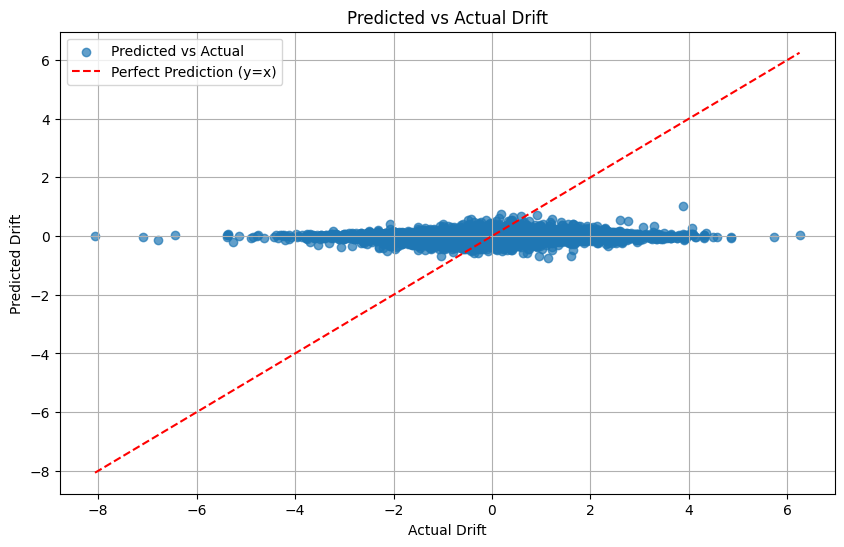

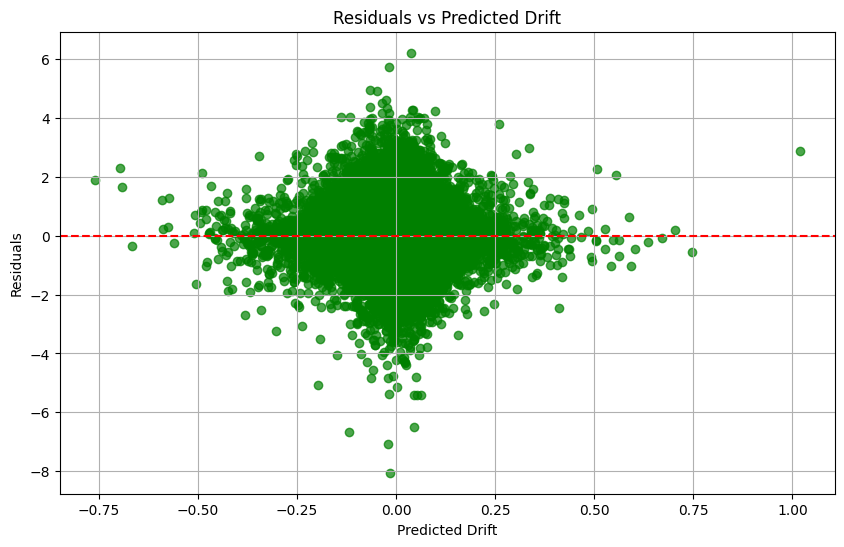

In [6]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Combine data for both stimuli
mean_activity = np.concatenate([mean_activity_r_1, mean_activity_r_2], axis=0)
drift = np.concatenate([drift_r_1, drift_r_2], axis=0)

# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(mean_activity, drift, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Step 2: Build the Neural Network
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(mean_activity.shape[1],)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(mean_activity.shape[1], activation='linear')  # Output layer for drift vector
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Step 3: Train the Model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    verbose=1
)

# Step 4: Evaluate the Model
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss (MSE): {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")

# Step 5: Analyze Predictions
# Predict on test data
predictions = model.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
accuracy = np.mean(np.abs(predictions - y_test) <= 0.1 * np.abs(y_test)) * 100  # ±10% tolerance

print(f"Test MSE: {mse:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"Accuracy: {accuracy:.2f}%")

# Step 6: Plot Predicted vs Actual Drift
plt.figure(figsize=(10, 6))
plt.scatter(y_test.flatten(), predictions.flatten(), alpha=0.7, label="Predicted vs Actual")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label="Perfect Prediction (y=x)")
plt.title("Predicted vs Actual Drift")
plt.xlabel("Actual Drift")
plt.ylabel("Predicted Drift")
plt.legend()
plt.grid()
plt.show()

# Step 7: Residual Analysis
residuals = y_test - predictions

plt.figure(figsize=(10, 6))
plt.scatter(predictions.flatten(), residuals.flatten(), alpha=0.7, color='green')
plt.axhline(y=0, color='red', linestyle='--')
plt.title("Residuals vs Predicted Drift")
plt.xlabel("Predicted Drift")
plt.ylabel("Residuals")
plt.grid()
plt.show()


In [24]:
print(mean_activity_r_1.max())

11.634273900313753


Epoch 1/50
6/6 [==============================] - 2s 112ms/step - loss: 0.4540 - mae: 0.4986 - val_loss: 0.4412 - val_mae: 0.4858
Epoch 2/50
6/6 [==============================] - 0s 39ms/step - loss: 0.4298 - mae: 0.4817 - val_loss: 0.4412 - val_mae: 0.4857
Epoch 3/50
6/6 [==============================] - 0s 41ms/step - loss: 0.4287 - mae: 0.4809 - val_loss: 0.4412 - val_mae: 0.4858
Epoch 4/50
6/6 [==============================] - 0s 40ms/step - loss: 0.4286 - mae: 0.4808 - val_loss: 0.4414 - val_mae: 0.4859
Epoch 5/50
6/6 [==============================] - 0s 41ms/step - loss: 0.4283 - mae: 0.4807 - val_loss: 0.4415 - val_mae: 0.4859
Epoch 6/50
6/6 [==============================] - 0s 39ms/step - loss: 0.4284 - mae: 0.4808 - val_loss: 0.4415 - val_mae: 0.4859
Epoch 7/50
6/6 [==============================] - 0s 38ms/step - loss: 0.4283 - mae: 0.4807 - val_loss: 0.4416 - val_mae: 0.4860
Epoch 8/50
6/6 [==============================] - 0s 39ms/step - loss: 0.4281 - mae: 0.4805 - va

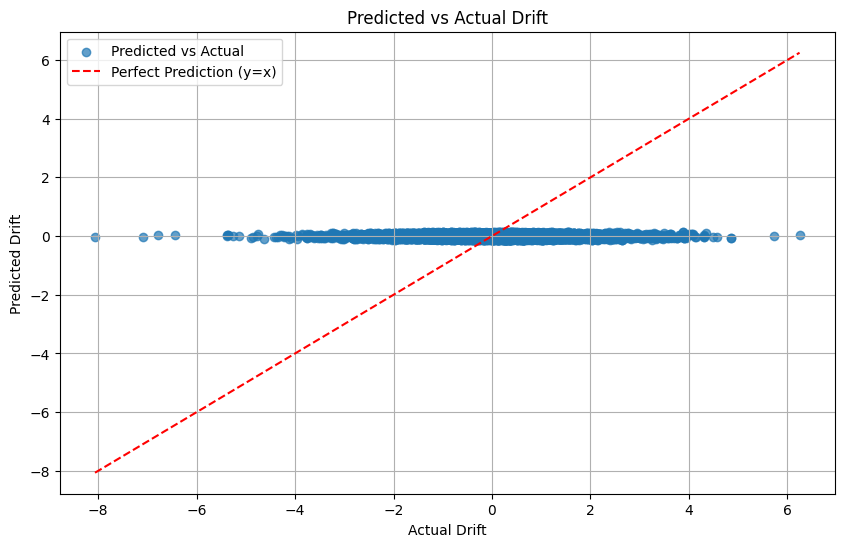

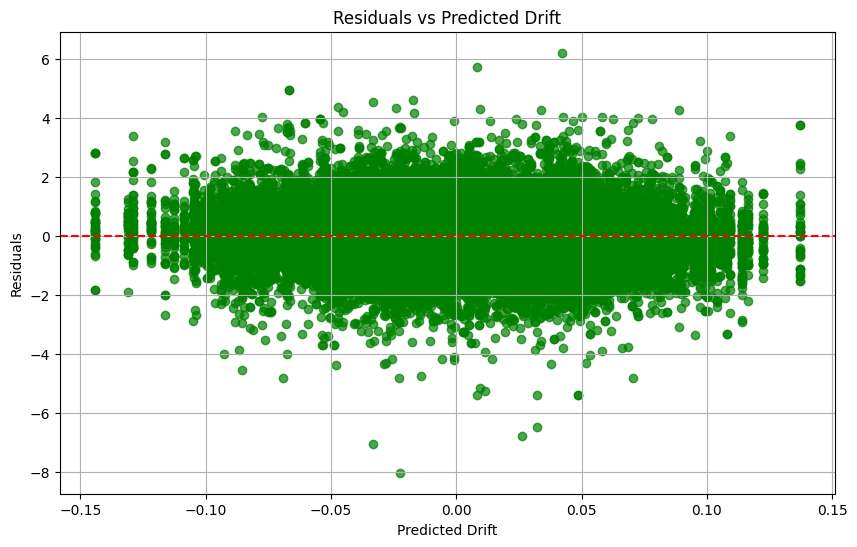

In [13]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Combine data for both stimuli
mean_activity = np.concatenate([mean_activity_r_1, mean_activity_r_2], axis=0)
drift = np.concatenate([drift_r_1, drift_r_2], axis=0)

# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(mean_activity, drift, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Step 2: Build the Neural Network
model = tf.keras.Sequential([
    tf.keras.layers.Dense(3124, activation='relu', input_shape=(mean_activity.shape[1],)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1562, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(781, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(781, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(781, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(781, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(781, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(mean_activity.shape[1], activation='linear')  # Output layer for drift vector
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Step 3: Train the Model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    verbose=1
)

# Step 4: Evaluate the Model
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss (MSE): {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")

# Step 5: Analyze Predictions
# Predict on test data
predictions = model.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
accuracy = np.mean(np.abs(predictions - y_test) <= 0.1 * np.abs(y_test)) * 100  # ±10% tolerance

print(f"Test MSE: {mse:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"Accuracy: {accuracy:.2f}%")

# Step 6: Plot Predicted vs Actual Drift
plt.figure(figsize=(10, 6))
plt.scatter(y_test.flatten(), predictions.flatten(), alpha=0.7, label="Predicted vs Actual")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label="Perfect Prediction (y=x)")
plt.title("Predicted vs Actual Drift")
plt.xlabel("Actual Drift")
plt.ylabel("Predicted Drift")
plt.legend()
plt.grid()
plt.show()

# Step 7: Residual Analysis
residuals = y_test - predictions

plt.figure(figsize=(10, 6))
plt.scatter(predictions.flatten(), residuals.flatten(), alpha=0.7, color='green')
plt.axhline(y=0, color='red', linestyle='--')
plt.title("Residuals vs Predicted Drift")
plt.xlabel("Predicted Drift")
plt.ylabel("Residuals")
plt.grid()
plt.show()


Epoch 1/50
6/6 [==============================] - 1s 33ms/step - loss: 1.2647 - mae: 0.9477 - val_loss: 0.8160 - val_mae: 0.7102
Epoch 2/50
6/6 [==============================] - 0s 16ms/step - loss: 0.7895 - mae: 0.6879 - val_loss: 0.4545 - val_mae: 0.5032
Epoch 3/50
6/6 [==============================] - 0s 16ms/step - loss: 0.5359 - mae: 0.5595 - val_loss: 0.3896 - val_mae: 0.4603
Epoch 4/50
6/6 [==============================] - 0s 16ms/step - loss: 0.4494 - mae: 0.5119 - val_loss: 0.3559 - val_mae: 0.4389
Epoch 5/50
6/6 [==============================] - 0s 16ms/step - loss: 0.3978 - mae: 0.4806 - val_loss: 0.4178 - val_mae: 0.4811
Epoch 6/50
6/6 [==============================] - 0s 18ms/step - loss: 0.3775 - mae: 0.4668 - val_loss: 0.4311 - val_mae: 0.4905
Epoch 7/50
6/6 [==============================] - 0s 17ms/step - loss: 0.3844 - mae: 0.4709 - val_loss: 0.3266 - val_mae: 0.4202
Epoch 8/50
6/6 [==============================] - 0s 18ms/step - loss: 0.3598 - mae: 0.4510 - val

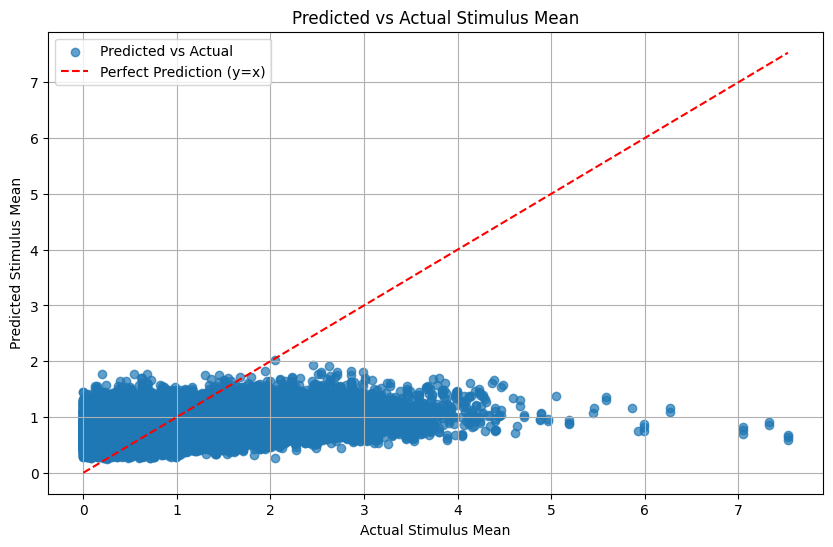

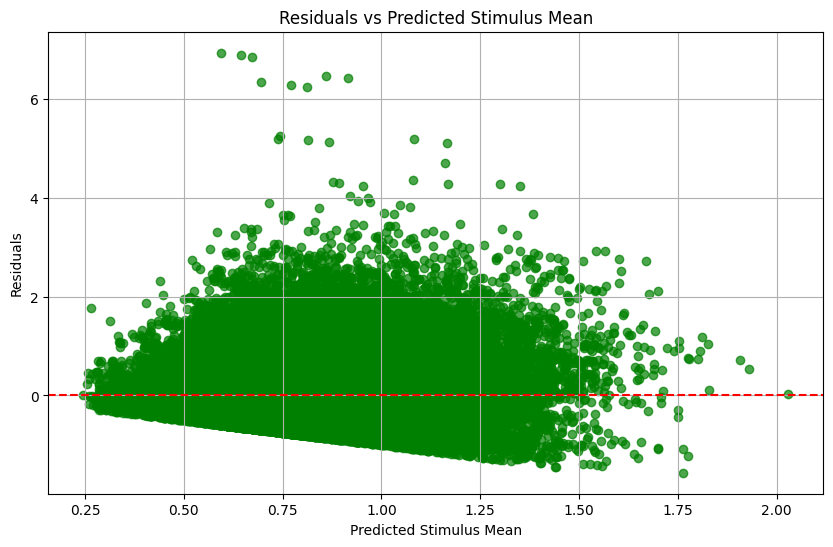

In [9]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Align activity with trial indices
mean_activity_cs_1 = mean_activity_cs_1[trial_r_1]  # Reactivation drift values for stimulus 1
mean_activity_cs_2 = mean_activity_cs_2[trial_r_2]  # Reactivation drift values for stimulus 2

# Combine data for both stimuli
mean_activity = np.concatenate([mean_activity_r_1, mean_activity_r_2], axis=0)
stimulus_mean = np.concatenate([mean_activity_cs_1, mean_activity_cs_2], axis=0)

# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(mean_activity, stimulus_mean, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Step 2: Build the Neural Network
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(mean_activity.shape[1],)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(mean_activity.shape[1], activation='linear')  # Output layer for stimulus mean
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Step 3: Train the Model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    verbose=1
)

# Step 4: Evaluate the Model
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss (MSE): {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")

# Step 5: Analyze Predictions
# Predict on test data
predictions = model.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
accuracy = np.mean(np.abs(predictions - y_test) <= 0.1 * np.abs(y_test)) * 100  # ±10% tolerance

print(f"Test MSE: {mse:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"Accuracy: {accuracy:.2f}%")

# Step 6: Plot Predicted vs Actual Stimulus Mean
plt.figure(figsize=(10, 6))
plt.scatter(y_test.flatten(), predictions.flatten(), alpha=0.7, label="Predicted vs Actual")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label="Perfect Prediction (y=x)")
plt.title("Predicted vs Actual Stimulus Mean")
plt.xlabel("Actual Stimulus Mean")
plt.ylabel("Predicted Stimulus Mean")
plt.legend()
plt.grid()
plt.show()

# Step 7: Residual Analysis
residuals = y_test - predictions

plt.figure(figsize=(10, 6))
plt.scatter(predictions.flatten(), residuals.flatten(), alpha=0.7, color='green')
plt.axhline(y=0, color='red', linestyle='--')
plt.title("Residuals vs Predicted Stimulus Mean")
plt.xlabel("Predicted Stimulus Mean")
plt.ylabel("Residuals")
plt.grid()
plt.show()


Epoch 1/50
6/6 [==============================] - 1s 62ms/step - loss: 2.5165 - mae: 1.2508 - val_loss: 1.3575 - val_mae: 1.0081
Epoch 2/50
6/6 [==============================] - 0s 41ms/step - loss: 0.9661 - mae: 0.7789 - val_loss: 0.4872 - val_mae: 0.5339
Epoch 3/50
6/6 [==============================] - 0s 39ms/step - loss: 0.5504 - mae: 0.5747 - val_loss: 0.5633 - val_mae: 0.5892
Epoch 4/50
6/6 [==============================] - 0s 40ms/step - loss: 0.4361 - mae: 0.5086 - val_loss: 0.8735 - val_mae: 0.7838
Epoch 5/50
6/6 [==============================] - 0s 41ms/step - loss: 0.4021 - mae: 0.4871 - val_loss: 0.9110 - val_mae: 0.8051
Epoch 6/50
6/6 [==============================] - 0s 40ms/step - loss: 0.3921 - mae: 0.4819 - val_loss: 0.7547 - val_mae: 0.7169
Epoch 7/50
6/6 [==============================] - 0s 39ms/step - loss: 0.3576 - mae: 0.4538 - val_loss: 0.6981 - val_mae: 0.6827
Epoch 8/50
6/6 [==============================] - 0s 39ms/step - loss: 0.3686 - mae: 0.4614 - val

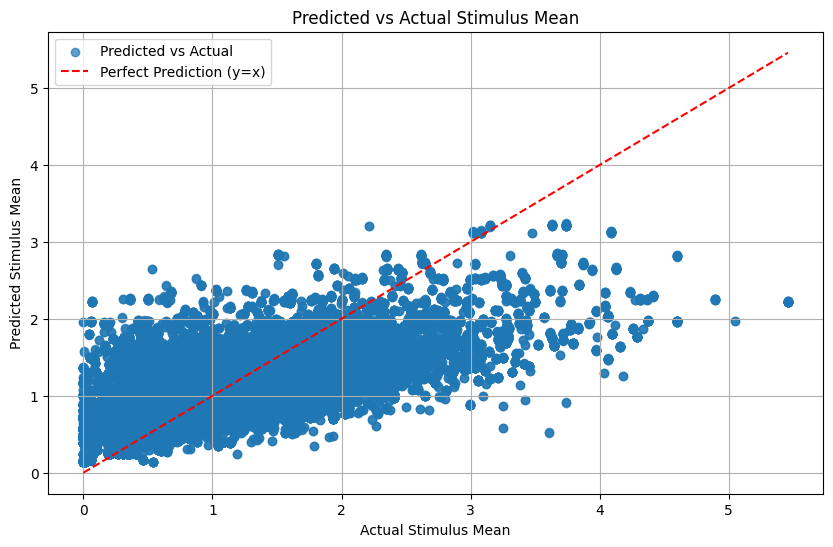

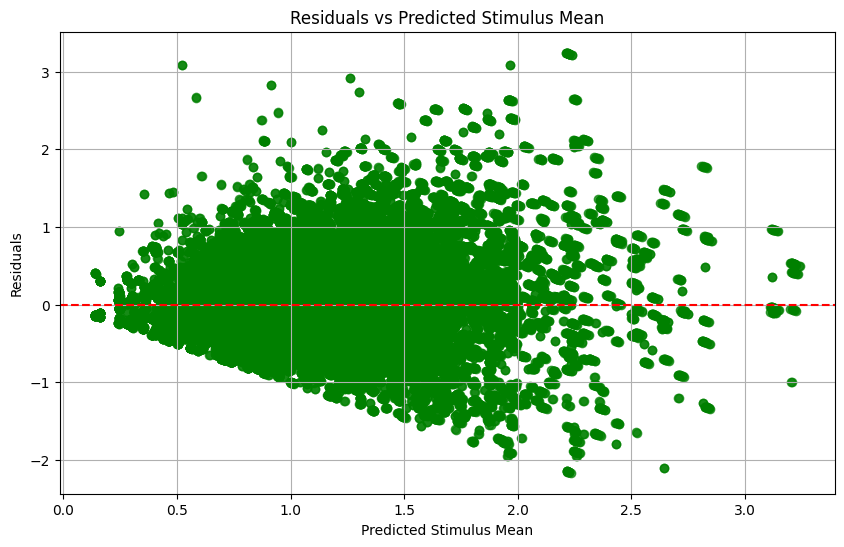

In [17]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Align activity with trial indices
mean_activity_cs_1 = mean_activity_cs_1[trial_r_1]  # Reactivation drift values for stimulus 1
mean_activity_cs_2 = mean_activity_cs_2[trial_r_2]  # Reactivation drift values for stimulus 2

# Combine data for both stimuli
mean_activity = np.concatenate([mean_activity_r_1, mean_activity_r_2], axis=0)
stimulus_mean = np.concatenate([mean_activity_cs_1, mean_activity_cs_2], axis=0)

# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(mean_activity, stimulus_mean, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Step 2: Build the Neural Network
# Step 2: Build the Neural Network
model = tf.keras.Sequential([
    tf.keras.layers.Dense(3124, activation='relu', input_shape=(mean_activity.shape[1],)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1562, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(781, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(781, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(781, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(781, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(781, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(mean_activity.shape[1], activation='linear')  # Output layer for drift vector
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Step 3: Train the Model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    verbose=1
)

# Step 4: Evaluate the Model
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss (MSE): {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")

# Step 5: Analyze Predictions
# Predict on test data
predictions = model.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
accuracy = np.mean(np.abs(predictions - y_test) <= 0.1 * np.abs(y_test)) * 100  # ±10% tolerance

print(f"Test MSE: {mse:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"Accuracy: {accuracy:.2f}%")

# Step 6: Plot Predicted vs Actual Stimulus Mean
plt.figure(figsize=(10, 6))
plt.scatter(y_test.flatten(), predictions.flatten(), alpha=0.7, label="Predicted vs Actual")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label="Perfect Prediction (y=x)")
plt.title("Predicted vs Actual Stimulus Mean")
plt.xlabel("Actual Stimulus Mean")
plt.ylabel("Predicted Stimulus Mean")
plt.legend()
plt.grid()
plt.show()

# Step 7: Residual Analysis
residuals = y_test - predictions

plt.figure(figsize=(10, 6))
plt.scatter(predictions.flatten(), residuals.flatten(), alpha=0.7, color='green')
plt.axhline(y=0, color='red', linestyle='--')
plt.title("Residuals vs Predicted Stimulus Mean")
plt.xlabel("Predicted Stimulus Mean")
plt.ylabel("Residuals")
plt.grid()
plt.show()

In [37]:
def compute_drift_per_trial(activity_matrix):
    """
    Compute drift (current trial - previous trial) for each neuron.
    :param activity_matrix: Trials x Neurons matrix of activity
    :return: Drift matrix (Trials-1 x Neurons)
    """
    return activity_matrix[1:, :] - activity_matrix[:-1, :]

drift_cs_1 = compute_drift_per_trial(mean_activity_r_1)  # Shape: (trials-1, neurons)
drift_cs_2 = compute_drift_per_trial(mean_activity_r_2)  # Shape: (trials-1, neurons)


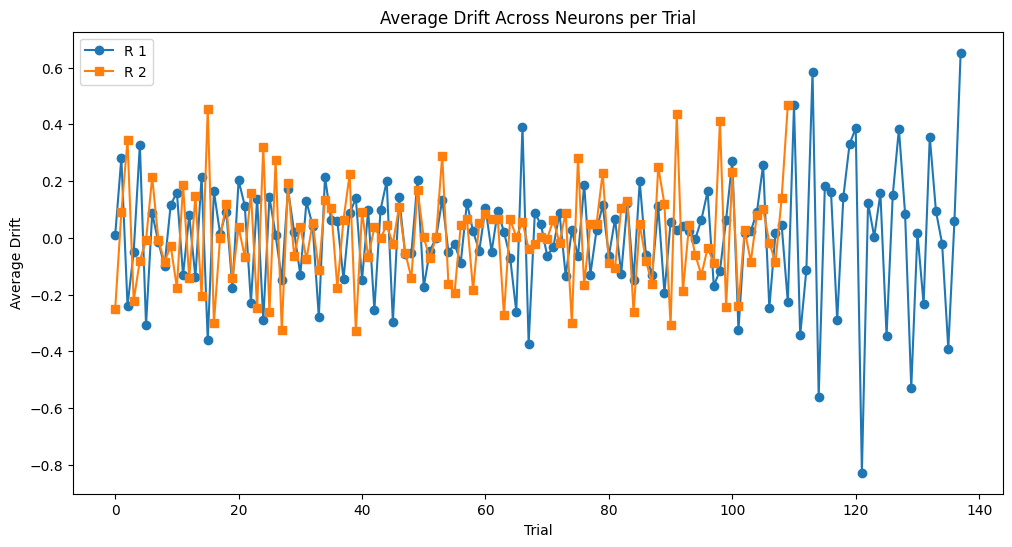

In [40]:
# Compute average drift per trial for CS 1 and CS 2
mean_drift_cs_1 = drift_cs_1.mean(axis=1)
mean_drift_cs_2 = drift_cs_2.mean(axis=1)

# Plot average drift across trials
plt.figure(figsize=(12, 6))
plt.plot(mean_drift_cs_1, label="R 1", marker="o")
plt.plot(mean_drift_cs_2, label="R 2", marker="s")
plt.title("Average Drift Across Neurons per Trial")
plt.xlabel("Trial")
plt.ylabel("Average Drift")
plt.legend()
plt.show()


In [39]:
import numpy as np
from scipy.spatial.distance import pdist

# Assuming drift_cs_1 and drift_cs_2 are NumPy arrays of shape (trials-1, neurons)
# Replace these with your actual data
# drift_cs_1 = ...
# drift_cs_2 = ...

# Compute pairwise distances for drift_cs_1 and drift_cs_2
pairwise_distances_cs_1 = pdist(drift_cs_1, metric='euclidean')
pairwise_distances_cs_2 = pdist(drift_cs_2, metric='euclidean')

# Calculate average pairwise distances
average_distance_cs_1 = np.mean(pairwise_distances_cs_1)
average_distance_cs_2 = np.mean(pairwise_distances_cs_2)

# Calculate maximum possible Euclidean distance based on the range of values (0 to ~5)
n_neurons = drift_cs_1.shape[1]  # Number of neurons (3124 in this case)
max_distance = np.sqrt(n_neurons * (5**2))

# Print results
print(f"Average pairwise distance for CS1: {average_distance_cs_1}")
print(f"Average pairwise distance for CS2: {average_distance_cs_2}")
print(f"Maximum possible Euclidean distance: {max_distance}")


Average pairwise distance for CS1: 50.157829339701514
Average pairwise distance for CS2: 47.30084567453321
Maximum possible Euclidean distance: 279.46377224964243


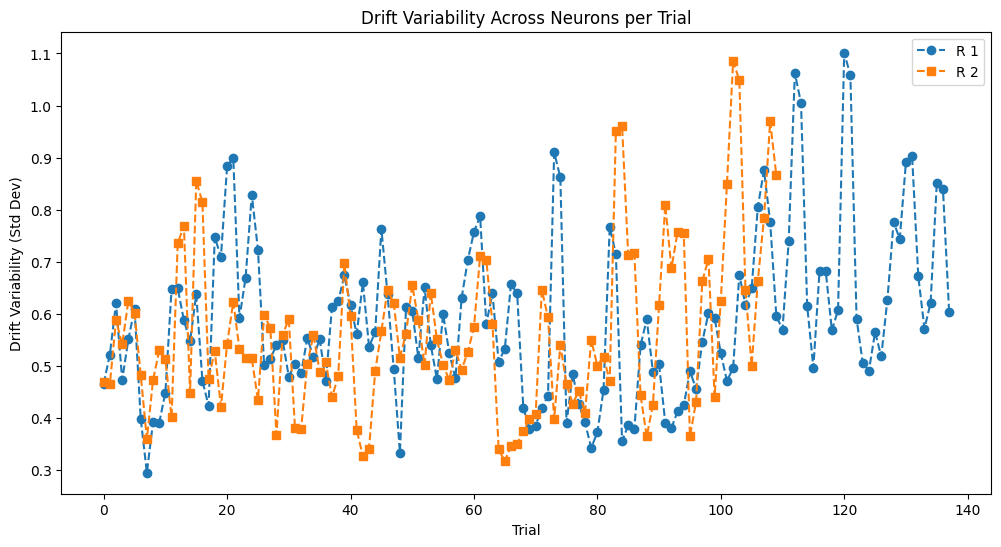

In [42]:
# Compute standard deviation of drift per trial for CS 1 and CS 2
std_drift_cs_1 = drift_cs_1.std(axis=1)
std_drift_cs_2 = drift_cs_2.std(axis=1)

# Plot drift variability across trials
plt.figure(figsize=(12, 6))
plt.plot(std_drift_cs_1, label="R 1", marker="o", linestyle="--")
plt.plot(std_drift_cs_2, label="R 2", marker="s", linestyle="--")
plt.title("Drift Variability Across Neurons per Trial")
plt.xlabel("Trial")
plt.ylabel("Drift Variability (Std Dev)")
plt.legend()
plt.show()

Mean Squared Error (MSE): 0.7011


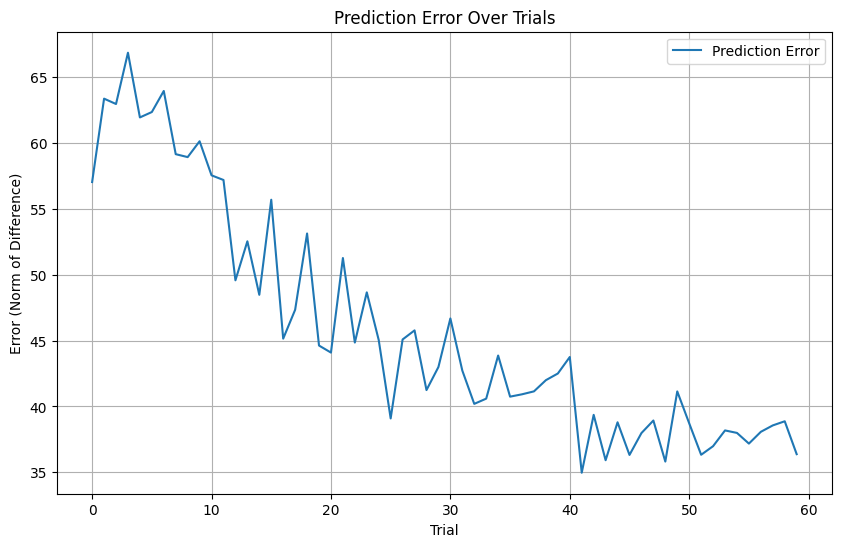

Optimal Plasticity Term: 0.1000, Best MSE: 0.5583


In [46]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Inputs
stimulus_evoked_initial = mean_activity_cs_1[0]  # Initial stimulus-evoked pattern for S1
reactivations = mean_activity_r_2  # Reactivations for S1
actual_patterns = mean_activity_cs_2  # Actual stimulus-evoked response patterns
plasticity_term = 0.05  # Example value for the plasticity term (can be optimized)

# Initialize predicted response patterns
predicted_patterns = np.zeros_like(actual_patterns)
predicted_patterns[0] = stimulus_evoked_initial  # Start with the initial pattern

# Iteratively update the predicted patterns
for t in range(1, len(actual_patterns)):
    reactivation = reactivations[t - 1]  # Reactivation for the current trial
    current_pattern = predicted_patterns[t - 1]  # Predicted pattern from the previous trial
    
    # Update rule
    predicted_patterns[t] = current_pattern + plasticity_term * (1.3 * reactivation - current_pattern)

# Calculate error metrics
mse = mean_squared_error(actual_patterns, predicted_patterns)
print(f"Mean Squared Error (MSE): {mse:.4f}")

# Visualize the predicted vs actual patterns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(len(actual_patterns)), np.linalg.norm(actual_patterns - predicted_patterns, axis=1), label="Prediction Error")
plt.title("Prediction Error Over Trials")
plt.xlabel("Trial")
plt.ylabel("Error (Norm of Difference)")
plt.legend()
plt.grid()
plt.show()

# Parametric optimization of the plasticity term
def optimize_plasticity_term(reactivations, actual_patterns, initial_pattern):
    best_alpha = None
    best_mse = float('inf')
    alphas = np.linspace(0.01, 0.1, 10)  # Example range for plasticity term

    for alpha in alphas:
        predicted_patterns = np.zeros_like(actual_patterns)
        predicted_patterns[0] = initial_pattern

        for t in range(1, len(actual_patterns)):
            reactivation = reactivations[t - 1]
            current_pattern = predicted_patterns[t - 1]
            predicted_patterns[t] = current_pattern + alpha * (1.3 * reactivation - current_pattern)

        mse = mean_squared_error(actual_patterns, predicted_patterns)
        if mse < best_mse:
            best_mse = mse
            best_alpha = alpha

    return best_alpha, best_mse

best_alpha, best_mse = optimize_plasticity_term(reactivations, actual_patterns, stimulus_evoked_initial)
print(f"Optimal Plasticity Term: {best_alpha:.4f}, Best MSE: {best_mse:.4f}")


Mean Squared Error (MSE): 0.7011
R² Score: -3.0732


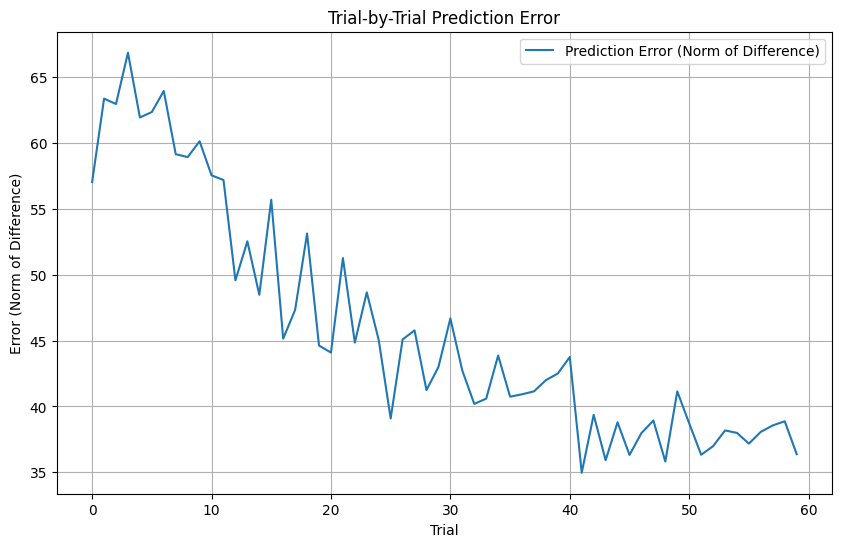

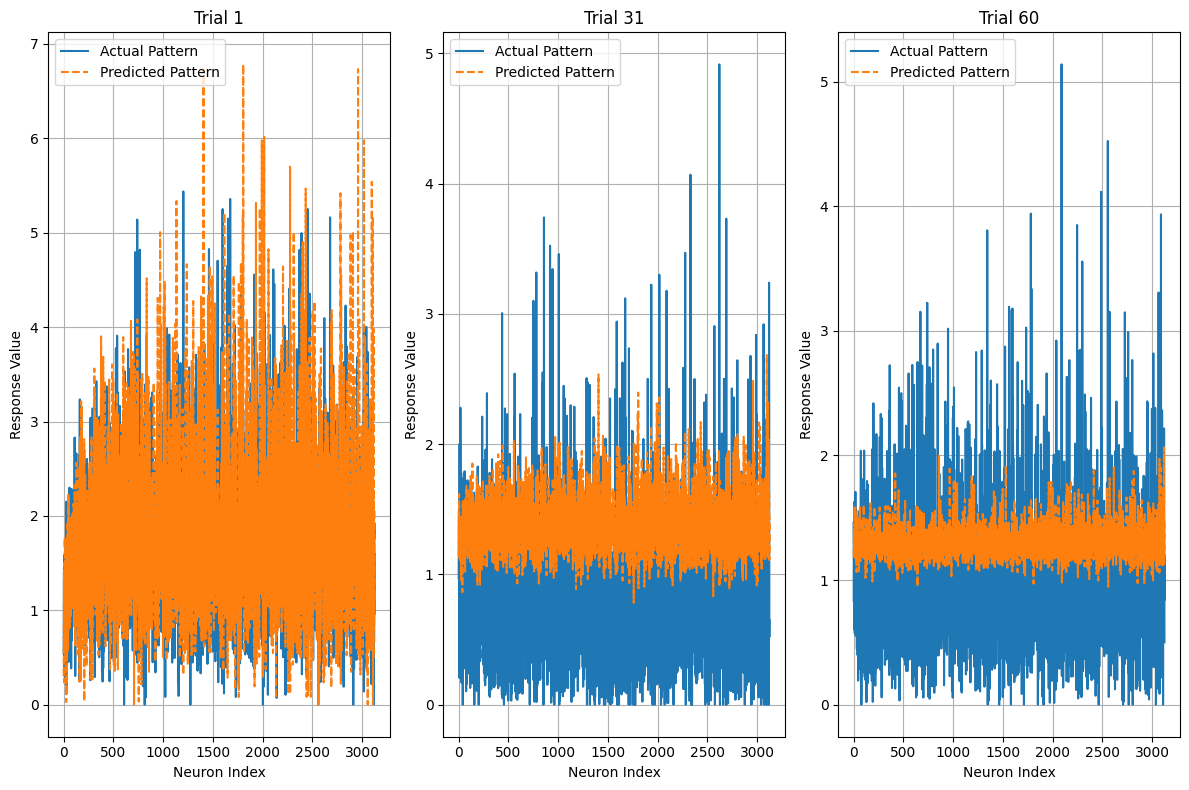

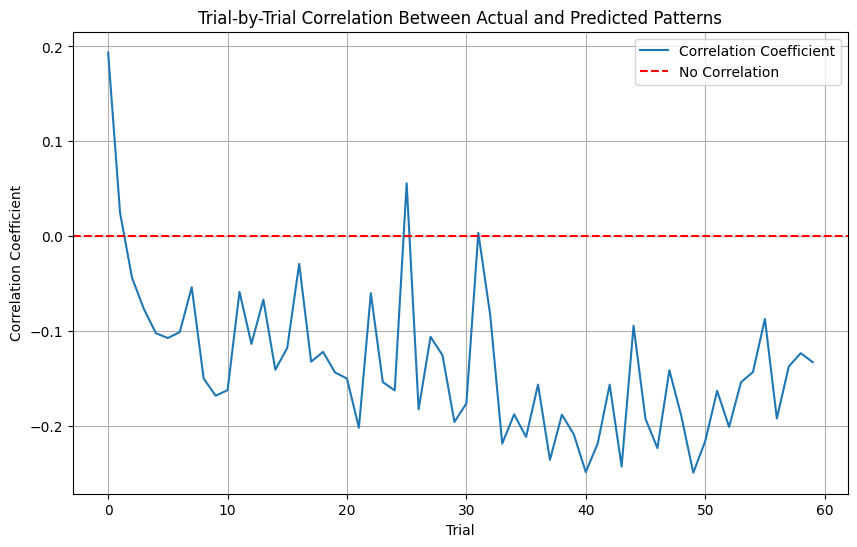

Average Correlation Across Trials: -0.1353


In [47]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Assume `actual_patterns`, `predicted_patterns` are computed from the heuristic model

# 1. Error Metrics
mse = mean_squared_error(actual_patterns, predicted_patterns)
r2 = r2_score(actual_patterns, predicted_patterns)
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R² Score: {r2:.4f}")

# 2. Trial-by-Trial Prediction Error
errors = np.linalg.norm(actual_patterns - predicted_patterns, axis=1)
plt.figure(figsize=(10, 6))
plt.plot(range(len(errors)), errors, label="Prediction Error (Norm of Difference)")
plt.title("Trial-by-Trial Prediction Error")
plt.xlabel("Trial")
plt.ylabel("Error (Norm of Difference)")
plt.legend()
plt.grid()
plt.show()

# 3. Visualization of Patterns for Selected Trials
selected_trials = [0, len(actual_patterns) // 2, len(actual_patterns) - 1]  # First, middle, and last trials

plt.figure(figsize=(12, 8))
for i, trial in enumerate(selected_trials):
    plt.subplot(1, 3, i + 1)
    plt.plot(actual_patterns[trial], label="Actual Pattern")
    plt.plot(predicted_patterns[trial], label="Predicted Pattern", linestyle="--")
    plt.title(f"Trial {trial + 1}")
    plt.xlabel("Neuron Index")
    plt.ylabel("Response Value")
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()

# 4. Correlation Analysis
correlations = [
    np.corrcoef(actual_patterns[trial], predicted_patterns[trial])[0, 1]
    for trial in range(len(actual_patterns))
]

plt.figure(figsize=(10, 6))
plt.plot(range(len(correlations)), correlations, label="Correlation Coefficient")
plt.axhline(y=0, color='red', linestyle='--', label="No Correlation")
plt.title("Trial-by-Trial Correlation Between Actual and Predicted Patterns")
plt.xlabel("Trial")
plt.ylabel("Correlation Coefficient")
plt.legend()
plt.grid()
plt.show()

print(f"Average Correlation Across Trials: {np.mean(correlations):.4f}")


In [50]:
from scipy.stats import t
# Group reactivations by trial indices
unique_trials_r1 = np.unique(trial_r_1)
unique_trials_r2 = np.unique(trial_r_2)

print(unique_trials_r1)

# Average r1 and r2 activity for each trial
mean_activity_r1_per_trial = np.zeros((len(unique_trials_r1), mean_activity_r_1.shape[1]))
mean_activity_r2_per_trial = np.zeros((len(unique_trials_r2), mean_activity_r_2.shape[1]))

for i, trial in enumerate(unique_trials_r1):
    trial_indices = np.where(trial_r_1 == trial)[0]
    mean_activity_r1_per_trial[i, :] = mean_activity_r_1[trial_indices, :].mean(axis=0)

for i, trial in enumerate(unique_trials_r2):
    trial_indices = np.where(trial_r_2 == trial)[0]
    mean_activity_r2_per_trial[i, :] = mean_activity_r_2[trial_indices, :].mean(axis=0)

# Step 2: Ensure alignment with drift datasets
# Align trials in drift_cs_1 and mean_activity_r1_per_trial
aligned_indices_r1 = np.isin(unique_trials_r1, np.arange(drift_cs_1.shape[0]))
aligned_indices_r2 = np.isin(unique_trials_r2, np.arange(drift_cs_2.shape[0]))

mean_activity_r1_aligned = mean_activity_r1_per_trial[aligned_indices_r1, :]
mean_activity_r2_aligned = mean_activity_r2_per_trial[aligned_indices_r2, :]

drift_cs_1_aligned = drift_cs_1[unique_trials_r1[aligned_indices_r1], :]
cs_2_aligned = drift_cs_2[unique_trials_r2[aligned_indices_r2], :]

# Step 3: Compute correlations for each neuron
# Compute correlations between r1 activity and drift_cs_1
correlations_r1 = [
    np.corrcoef(mean_activity_r1_aligned[:, neuron], drift_cs_1_aligned[:, neuron])[0, 1]
    for neuron in range(mean_activity_r1_aligned.shape[1])
]

# Compute correlations between r2 activity and cs_2
correlations_r2 = [
    np.corrcoef(mean_activity_r2_aligned[:, neuron], cs_2_aligned[:, neuron])[0, 1]
    for neuron in range(mean_activity_r2_aligned.shape[1])
]

def correlation_p_value(r, n):
    """Compute the p-value for a given correlation coefficient."""
    t_stat = r * np.sqrt((n - 2) / (1 - r**2))
    p_value = 2 * t.sf(np.abs(t_stat), df=n - 2)  # Two-tailed test
    return p_value

# Step 1: Compute p-values for r1
num_trials = mean_activity_r1_aligned.shape[0]
p_values_r1 = [correlation_p_value(r, num_trials) for r in correlations_r1]

# Step 2: Compute p-values for r2
num_trials_r2 = mean_activity_r2_aligned.shape[0]
p_values_r2 = [correlation_p_value(r, num_trials_r2) for r in correlations_r2]

# Step 3: Identify significant neurons
significant_neurons_r1 = [neuron for neuron, p in enumerate(p_values_r1) if p < 0.05]
significant_neurons_r2 = [neuron for neuron, p in enumerate(p_values_r2) if p < 0.05]

# Step 4: Print significant neurons
print(f"Significant neurons from r1: {len(significant_neurons_r1)} out of {len(correlations_r1)}")
print(f"Significant neurons from r2: {len(significant_neurons_r2)} out of {len(correlations_r2)}")




[ 1  2  3  4  5  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 23 24 25 26
 27 28 29 30 31 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 50 51 52
 53 54 55 56 57 58 59 60 61 62 63 64 65 66]
Significant neurons from r1: 126 out of 3124
Significant neurons from r2: 118 out of 3124


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Assuming mean_drift_cs_1 and mean_overlap_cs_1 are precomputed
mean_drift_cs_1 = drift_cs_1.mean(axis=1)  # Mean across neurons for each trial
mean_overlap_cs_1 = r1_sig_act[:-1, ].mean(axis=1)

# Reshape data for regression
X = mean_overlap_cs_1.reshape(-1, 1)  # Input: Overlapping activity
y = mean_drift_cs_1  # Output: Drift activity

# Fit a linear regression model
model = LinearRegression()
model.fit(X, y)

# Predict drift activity
predicted_drift = model.predict(X)

# Residuals
residuals = y - predicted_drift

# Metrics
mse = mean_squared_error(y, predicted_drift)
r2 = r2_score(y, predicted_drift)
accuracy = np.mean(np.abs(predicted_drift - y) <= 0.1 * np.abs(y)) * 100

print(f"MSE: {mse:.4f}, R-squared: {r2:.4f}, Accuracy: {accuracy:.2f}%")


# Visualization: Predicted vs Actual Drift Activity
plt.figure(figsize=(10, 6))
plt.scatter(y.flatten(), predicted_drift.flatten(), alpha=0.8, color='blue', label="Predicted vs Actual")
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--', label="Perfect Prediction (y=x)")
plt.title("Predicted vs Actual Drift Activity")
plt.xlabel("Actual Drift Activity")
plt.ylabel("Predicted Drift Activity")
plt.legend()
plt.grid()
plt.show()

# Visualization: Residuals vs Predicted Drift
plt.figure(figsize=(10, 6))
plt.scatter(predicted_drift, residuals, alpha=0.8, color='green')
plt.axhline(y=0, color='red', linestyle='--')
plt.title("Residuals vs Predicted Drift Activity")
plt.xlabel("Predicted Drift Activity")
plt.ylabel("Residuals")
plt.grid()
plt.show()

# Histogram of Residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, color='purple', alpha=0.7, edgecolor='black')
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.show()
